# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Bootcamp/W4_DL/C1_M4_Core_NN_Components/WeeklyProject-20260110T052518Z-1-001/WeeklyProject"

/content/drive/MyDrive/Bootcamp/W4_DL/C1_M4_Core_NN_Components/WeeklyProject-20260110T052518Z-1-001/WeeklyProject


In [ ]:
import torch
torch._dynamo.disable()

In [ ]:
# YOUR CODE HERE


import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import helper_utils


## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [ ]:
import kagglehub

# Download Intel Image Classification dataset
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


In [ ]:
# YOUR CODE HERE

data_dir = path

train_dir = os.path.join(data_dir, "seg_train", "seg_train")
test_dir  = os.path.join(data_dir, "seg_test", "seg_test")

print("Train dir exists:", os.path.exists(train_dir))
print("Test dir exists:", os.path.exists(test_dir))


Train dir exists: True
Test dir exists: True


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [ ]:
# YOUR CODE HERE

from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=train_dir)
test_dataset  = ImageFolder(root=test_dir)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [ ]:
# YOUR CODE HERE

print("Number of training images:", len(train_dataset))
print("Number of test images:", len(test_dataset))


Number of training images: 14034
Number of test images: 3000


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# YOUR CODE HERE

from torchvision import transforms

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}


In [ ]:
# YOUR CODE HERE

from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(
    root=train_dir,
    transform=data_transforms["train"]
)

val_dataset = ImageFolder(
    root=test_dir,
    transform=data_transforms["val"]
)


**Quick Check**: Visualize a batch of training images

In [ ]:
# YOUR CODE HERE

from torch.utils.data import DataLoader

batch_size = 32

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}

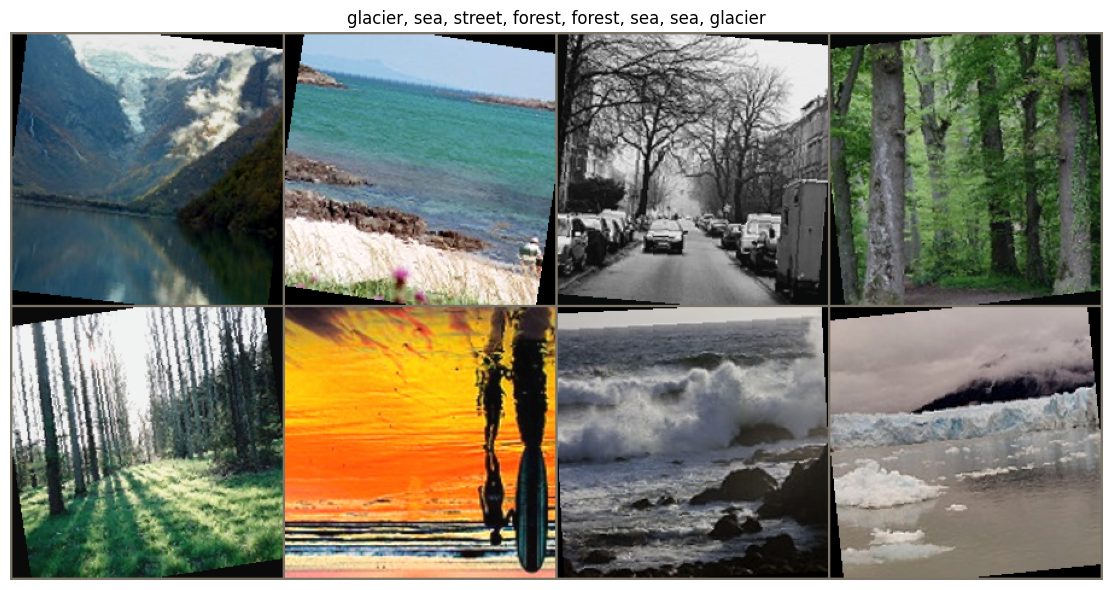

In [ ]:
helper_utils.visualize_batch(
    dataloaders["train"],
    class_names,
    num_images=8
)


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [ ]:
# YOUR CODE HERE

import torch.nn as nn
from torchvision import models


model = models.resnet18(pretrained=True)


num_ftrs = model.fc.in_features


model.fc = nn.Linear(num_ftrs, num_classes)


model = model.to(device)

print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [ ]:
# YOUR CODE HERE

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        print()

    return model, history


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [ ]:
# YOUR CODE HERE

model_conv = models.resnet18(pretrained=True)

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)


In [ ]:
# YOUR CODE HERE

for param in model_conv.parameters():
    param.requires_grad = False

for param in model_conv.fc.parameters():
    param.requires_grad = True


In [ ]:
# YOUR CODE HERE

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)


In [ ]:
# YOUR CODE HERE

model_conv, history_conv = train_model(
    model_conv,
    dataloaders,
    criterion,
    optimizer_conv,
    device,
    num_epochs=5
)


Epoch 1/5
------------------------------
train Loss: 0.5588 Acc: 0.8221
val Loss: 0.3198 Acc: 0.8883

Epoch 2/5
------------------------------
train Loss: 0.3589 Acc: 0.8725
val Loss: 0.2846 Acc: 0.8980

Epoch 3/5
------------------------------
train Loss: 0.3417 Acc: 0.8761
val Loss: 0.2952 Acc: 0.8917

Epoch 4/5
------------------------------
train Loss: 0.3299 Acc: 0.8801
val Loss: 0.2649 Acc: 0.9023

Epoch 5/5
------------------------------
train Loss: 0.3176 Acc: 0.8829
val Loss: 0.2674 Acc: 0.9030



**Quick Check**: Visualize training history

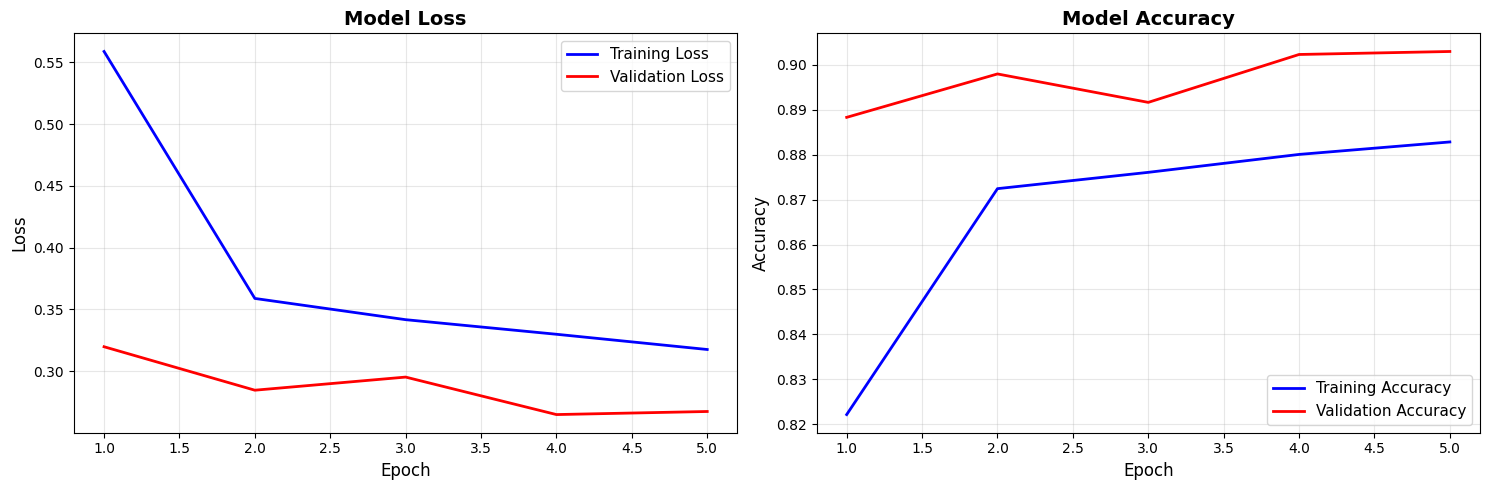

In [ ]:
helper_utils.visualize_training_history(history_conv)
plt.show()

**Quick Check**: Visualize predictions

In [ ]:
helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [ ]:
# YOUR CODE HERE

model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)


In [ ]:
# YOUR CODE HERE

for param in model_ft.parameters():
    param.requires_grad = True


In [ ]:
# YOUR CODE HERE

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(
    model_ft.parameters(),
    lr=1e-4
)


In [ ]:
# YOUR CODE HERE

model_ft, history_ft = train_model(
    model_ft,
    dataloaders,
    criterion,
    optimizer_ft,
    device,
    num_epochs=5
)


Epoch 1/5
------------------------------
train Loss: 0.3115 Acc: 0.8928
val Loss: 0.2047 Acc: 0.9217

Epoch 2/5
------------------------------
train Loss: 0.1953 Acc: 0.9300
val Loss: 0.2153 Acc: 0.9167

Epoch 3/5
------------------------------
train Loss: 0.1579 Acc: 0.9426
val Loss: 0.1904 Acc: 0.9350

Epoch 4/5
------------------------------
train Loss: 0.1246 Acc: 0.9542
val Loss: 0.2070 Acc: 0.9277

Epoch 5/5
------------------------------
train Loss: 0.1011 Acc: 0.9642
val Loss: 0.2240 Acc: 0.9220



**Quick Check**: Visualize training history

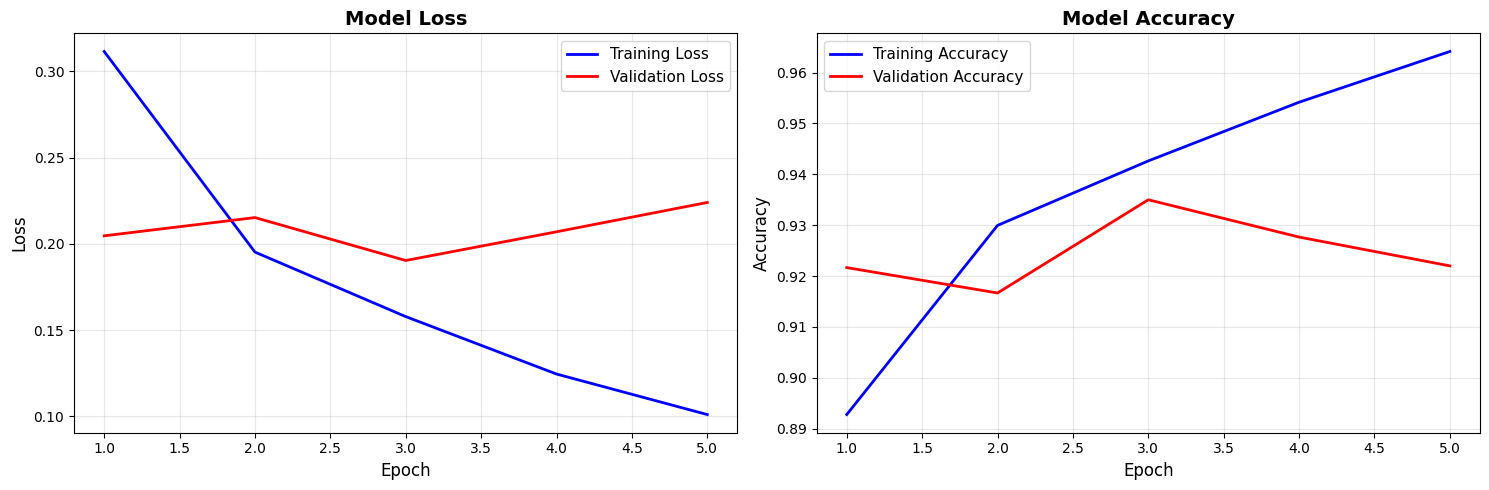

In [ ]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

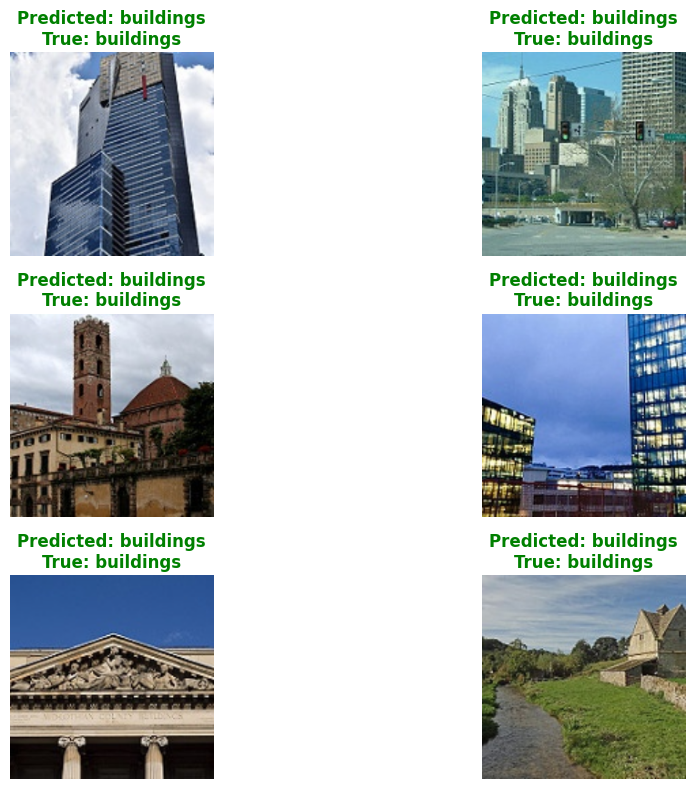

In [ ]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [ ]:
# Evaluate models on validation set
# YOUR CODE HERE



# Feature Extractor
best_val_conv = max(history_conv["val_acc"])
final_val_conv = history_conv["val_acc"][-1]

# Fine-tuning
best_val_ft = max(history_ft["val_acc"])
final_val_ft = history_ft["val_acc"][-1]

print("<<<< Model Evaluation & Comparison >>>>")
print()
print("Feature Extractor Approach:")
print(f"   Best Val Accuracy : {best_val_conv:.4f}")
print(f"   Final Val Accuracy: {final_val_conv:.4f}")
print()
print("Fine-tuning Approach:")
print(f"   Best Val Accuracy : {best_val_ft:.4f}")
print(f"   Final Val Accuracy: {final_val_ft:.4f}")





# Compare final validation accuracies, training times, etc.

# Print comparison
# print("Feature Extractor Approach:")
# print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
# print()
# print("Fine-tuning Approach:")
# print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

<<<< Model Evaluation & Comparison >>>>

Feature Extractor Approach:
   Best Val Accuracy : 0.9030
   Final Val Accuracy: 0.9030

Fine-tuning Approach:
   Best Val Accuracy : 0.9350
   Final Val Accuracy: 0.9220


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

Using test image: /kaggle/input/intel-image-classification/seg_test/seg_test/buildings/22735.jpg


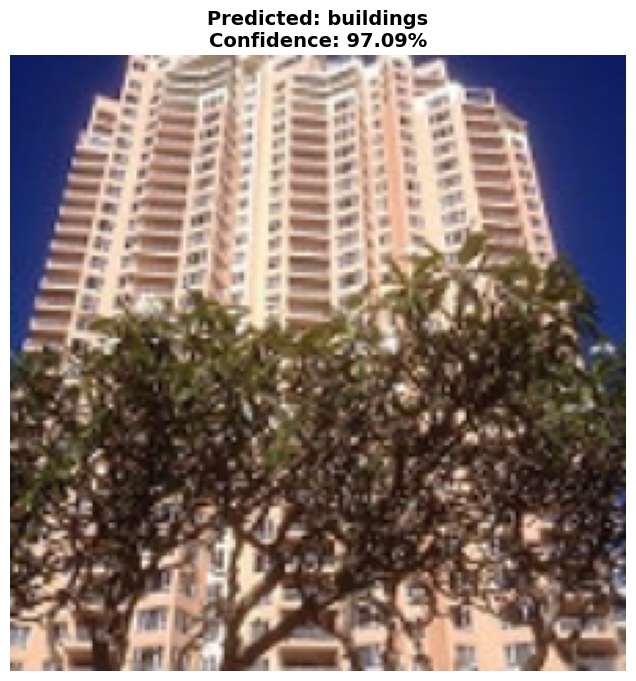

In [ ]:
# Make prediction on a custom image
# img_path = 'path/to/your/image.jpg'

# YOUR CODE HERE



import os

# اخترت الصوره من seg_test (غير مستخدمة في التدريب)
img_path = os.path.join(
    test_dir,
    "buildings",
    os.listdir(os.path.join(test_dir, "buildings"))[0]
)

print("Using test image:", img_path)


helper_utils.visualize_single_prediction(
    model_ft,
    img_path,
    data_transforms["val"],
    class_names,
    device
)

plt.show()

# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
# helper_utils.visualize_single_prediction(
#     model_ft,  # or model_conv
#     img_path,
#     data_transforms['val'],
#     class_names,
#     device
# )
# plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [ ]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [ ]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")